# Imports

In [ ]:
!pip install tf-explain
# !pip install tensorflow==2.5.0

     |████████████████████████████████| 43 kB 1.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

from sklearn.metrics import mean_absolute_error, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import keras
from keras.layers import *
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow import one_hot
from keras.activations import tanh
from keras.models import Sequential,Model

pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
import tensorflow as tf
tf.__version__

'2.7.0'

# Load data from eICU and MIMIC-IV

In [4]:
eicu = pd.read_csv("./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/eicu_vitals_treatments_drug_cumsum.csv")
# mimic = pd.read_csv("./drive/MyDrive/AI Datathon/mimic-iv-1.0/mimic_iv_icp_all_codes_filtered.csv")

def f(x):
    if math.isnan(x['systemicmean']):
        if (not math.isnan(x['Non-Invasive BP - Non-Invasive BP Diastolic'])) and (not math.isnan(x['Non-Invasive BP - Non-Invasive BP Systolic'])):
            return 2/3*x['Non-Invasive BP - Non-Invasive BP Diastolic']+1/3*x['Non-Invasive BP - Non-Invasive BP Systolic']
        elif (not math.isnan(x['Invasive BP - Invasive BP Diastolic'])) and (not math.isnan(x['Invasive BP - Invasive BP Systolic'])):
            return x['Invasive BP - Invasive BP Systolic']*1/3+2/3*x['Invasive BP - Invasive BP Diastolic']
        else:
            return np.nan
    else:
        return x['systemicmean']

eicu['systemicmean'] = eicu.apply(lambda x: f(x),axis=1)

bad_bp_patient = eicu[eicu['systemicmean'].isna()]['patientunitstayid'].unique()
# bad_gcs_patient = eicu[eicu['Glasgow coma score - GCS Total'].isna()]['patientunitstayid'].unique()
bad_respiration_patient = eicu[eicu['respiration'].isna()]['patientunitstayid'].unique()
# print(len(bad_bp_patient),len(bad_gcs_patient),len(bad_respiration_patient))
bad_patients3 = np.concatenate([bad_bp_patient,bad_respiration_patient])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
eicu.head()

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,systemicsystolic,systemicdiastolic,systemicmean,icp,Glasgow coma score - GCS Total,Invasive BP - Invasive BP Diastolic,Invasive BP - Invasive BP Systolic,Non-Invasive BP - Non-Invasive BP Diastolic,Non-Invasive BP - Non-Invasive BP Systolic,Intracranial operations,Lumbar Puncture,Mechanical Ventilation,Neurovascular Procedures,Shunting,hypertonic saline,mannitol,Culmulative Intracranial operations,Culmulative Lumbar Puncture,Culmulative Mechanical Ventilation,Culmulative Neurovascular Procedures,Culmulative Shunting,Culmulative hypertonic saline,Culmulative mannitol
0,39121950,143881,450,26.2,100.0,68.0,29.0,148.0,44.0,70.0,11.0,6,50.0,164.0,61.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39121791,143881,455,26.2,100.0,66.0,28.0,146.0,44.0,70.0,20.0,6,50.0,164.0,61.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39121631,143881,460,26.2,100.0,68.0,27.0,150.0,46.0,72.0,5.0,6,46.0,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39121469,143881,465,26.2,99.0,64.0,18.0,146.0,44.0,70.0,-7.0,6,46.0,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39121308,143881,470,26.2,100.0,68.0,19.0,148.0,46.0,70.0,-15.0,6,46.0,156.0,54.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# eicu['medicine'] = np.nan
# eicu['medicine'].loc[eicu['hypertonic saline']>0] = 1
# eicu['medicine'].loc[eicu['mannitol']>0] = 1
# eicu['medicine'].fillna(0)
# eicu

In [5]:
# patient_diagnoses = pd.read_csv("./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/eicu_patient_diagnoses.csv")
# patients_basic_info = pd.read_csv("./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/eicu_patients_basic_info.csv")

patients_static = pd.read_csv("./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/eicu_static_features.csv")
patients_static = patients_static.iloc[:,1:]

In [6]:
# convert to onehot encoding for basic info categorical
# patients_static_one_hot = pd.get_dummies(patients_static)
# patients_static_one_hot.to_csv('./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/patients_info_diagnoses_filtered.csv')
patients_static_one_hot = patients_static
patients_static_one_hot['bmi'] = patients_static_one_hot['admissionweight']/(patients_static_one_hot['admissionheight']/100)**2
patients_static_one_hot = patients_static_one_hot[['patientunitstayid','age','bmi','GCS']]

bad_patients = patients_static_one_hot[patients_static_one_hot['GCS'].isna()]['patientunitstayid'].unique()

In [ ]:
# patients_basic_info_filtered = patients_basic_info.copy()
# patients_basic_info_filtered['ethnicity']=patients_basic_info_filtered['ethnicity'].fillna('Other/Unknown')
# patients_basic_info_filtered=patients_basic_info_filtered.dropna()

In [ ]:
# patients_basic_info_filtered.to_csv('./drive/MyDrive/AI Datathon/eicu-collaborative-research-database-2.0/patients_info_diagnoses_filtered')

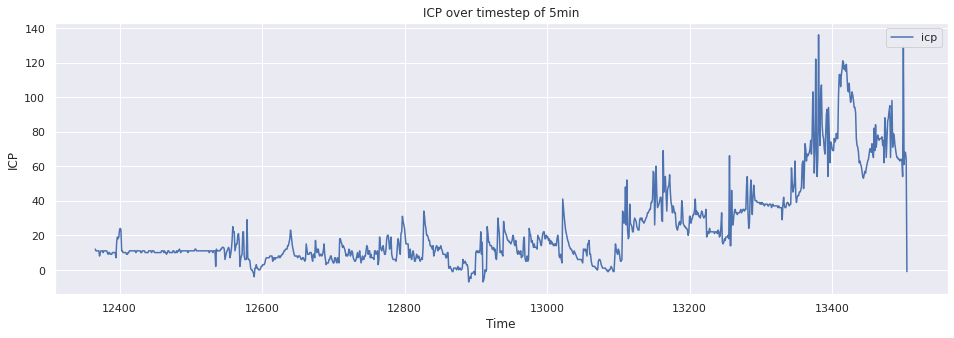

In [ ]:
# Sample ICP plot
eicu[eicu['patientunitstayid']==172448].plot(y=['icp'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP');

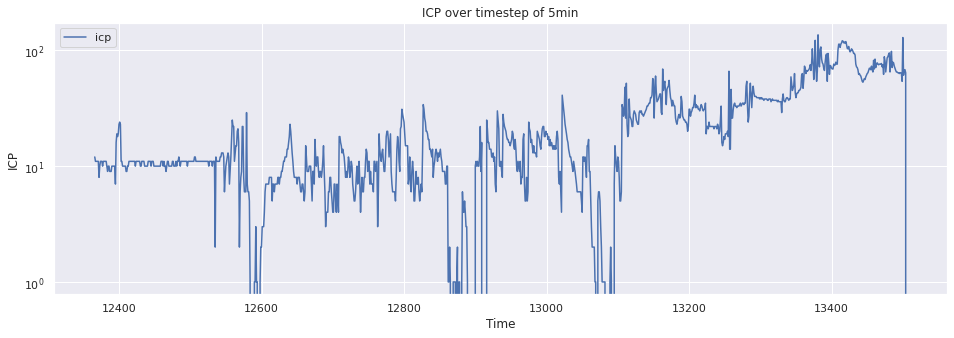

In [ ]:
# Sample ICP plot
eicu[eicu['patientunitstayid']==172448].plot(y=['icp'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP',logy=True);

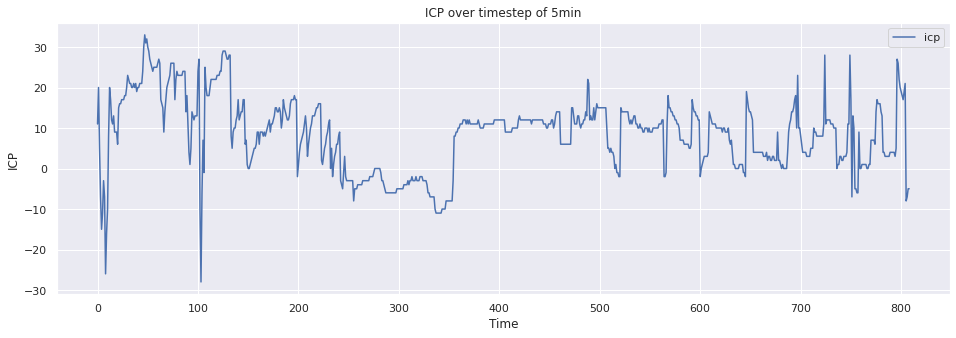

In [ ]:
# Sample ICP plot 2, seems like there were interventions, but if interventions were like very fast, and treated as random
# fluctuations, then it should affect our momentum results, that will ideally predict a up/downward trend if it was consistent
# for the past 5 steps e.g.
eicu[eicu['patientunitstayid']==143881].plot(y=['icp'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP');

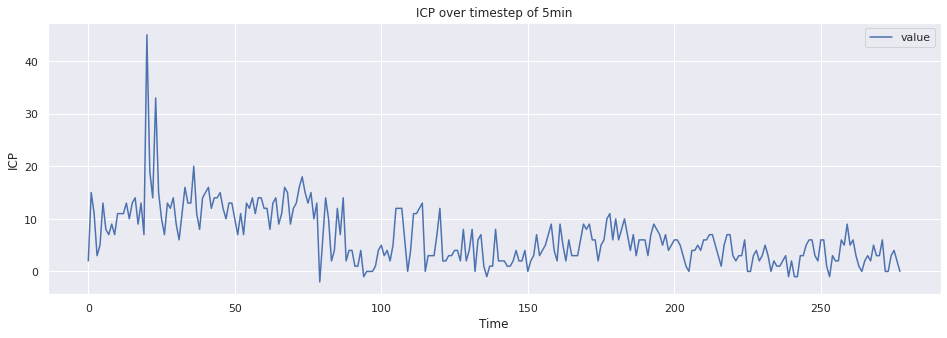

In [ ]:
mimic[mimic['subject_id']==10419568].plot(y=['value'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP');

# Preprocess Data
* First, we need to change the ICP values to a change in ICP from between time = t and time = t+1
* Next, split both MIMIC and eICU data into training and testing sets.
* Second, we normalise the values based on the MinMax of the training data

### Get ICP change

In [ ]:
eicu_patients = eicu['patientunitstayid'].unique()
eicu_diff = eicu.copy()
for patient in eicu_patients:
    eicu_diff.loc[eicu_diff['patientunitstayid']==patient,'icp_change']=eicu_diff[eicu_diff['patientunitstayid']==patient]['icp'].diff().values

In [ ]:
mimic_patients = mimic['subject_id'].unique()
mimic_diff = mimic.copy()
for patient in mimic_patients:
    mimic_diff.loc[mimic_diff['subject_id']==patient,'icp_change']=mimic_diff[mimic_diff['subject_id']==patient]['value'].diff().values

### Generate training and testing sets

In [7]:
# Applying Exponential Moving Average to smoothen training data only so we
# don't predict the numerous fluctuations

def ema_smooth_fn(patient_icp):
    EMA = 0.0
    gamma = 0.1
    patient_icp_smooth = patient_icp.copy()
    for ti in range(len(patient_icp_smooth)):
        EMA = gamma*patient_icp_smooth[ti] + (1-gamma)*EMA
        patient_icp_smooth[ti] = EMA
    return patient_icp_smooth

eicu_patients = eicu['patientunitstayid'].unique()
for patient in eicu_patients:
    eicu.loc[eicu['patientunitstayid']==patient, 'icp_ema'] = ema_smooth_fn(eicu[eicu['patientunitstayid']==patient]['icp'].values)

In [8]:
bad_patients2 = eicu[eicu['icp_ema']>100]['patientunitstayid'].unique()

In [9]:
np.random.seed(100)
print(len(eicu_patients))
eicu_patients = eicu_patients[np.isin(eicu_patients,bad_patients,invert=True)]
eicu_patients = eicu_patients[np.isin(eicu_patients,bad_patients2,invert=True)]
eicu_patients = eicu_patients[np.isin(eicu_patients,bad_patients3,invert=True)]
print(len(eicu_patients))
np.random.shuffle(eicu_patients)
# np.random.shuffle(mimic_patients)

868
789


In [10]:
training_ratio = 0.7
validation_ratio = 0.1

eicu_patient_training = eicu_patients[:int(training_ratio*len(eicu_patients))]
eicu_patient_validation = eicu_patients[int(training_ratio*len(eicu_patients)):int((training_ratio+validation_ratio)*len(eicu_patients))]
eicu_patient_testing = eicu_patients[int((training_ratio+validation_ratio)*len(eicu_patients)):]
# eicu_patient_training = pd.read_csv('./drive/MyDrive/AI Datathon/eicu_patient_training.csv').iloc[:,1:].values.flatten()
# eicu_patient_testing = pd.read_csv('./drive/MyDrive/AI Datathon/eicu_patient_testing.csv').iloc[:,1:].values.flatten()
# mimic_patient_training = mimic_patients[:int(training_ratio*len(mimic_patients))]
# mimic_patient_testing = mimic_patients[int(training_ratio*len(mimic_patients)):]

eicu_diff_training = eicu[eicu['patientunitstayid'].isin(eicu_patient_training)]
# mimic_diff_training = mimic_diff[mimic_diff['subject_id'].isin(mimic_patient_training)]
eicu_diff_validation = eicu[eicu['patientunitstayid'].isin(eicu_patient_validation)]
eicu_diff_testing = eicu[eicu['patientunitstayid'].isin(eicu_patient_testing)]
# mimic_diff_testing = mimic_diff[mimic_diff['subject_id'].isin(mimic_patient_testing)]

eicu_static_training = patients_static_one_hot[patients_static_one_hot['patientunitstayid'].isin(eicu_patient_training)]
eicu_static_validation = patients_static_one_hot[patients_static_one_hot['patientunitstayid'].isin(eicu_patient_validation)]
eicu_static_testing = patients_static_one_hot[patients_static_one_hot['patientunitstayid'].isin(eicu_patient_testing)]

In [11]:
eicu_diff_training = eicu_diff_training[eicu_diff_training['patientunitstayid'].isin(eicu_static_training['patientunitstayid'].values)]
eicu_diff_training['patientunitstayid'].nunique()
eicu_diff_validation = eicu_diff_validation[eicu_diff_validation['patientunitstayid'].isin(eicu_static_validation['patientunitstayid'].values)]
eicu_diff_validation['patientunitstayid'].nunique()
eicu_diff_testing = eicu_diff_testing[eicu_diff_testing['patientunitstayid'].isin(eicu_static_testing['patientunitstayid'].values)]
eicu_diff_testing['patientunitstayid'].nunique()

157

Text(0, 0.5, 'Counts (Log Scale)')

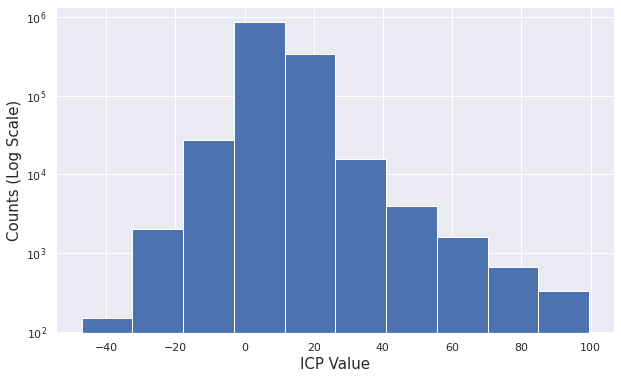

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(eicu_diff_training['icp_ema'], log=True);
plt.xlabel('ICP Value',fontsize=15)
plt.ylabel('Counts (Log Scale)',fontsize=15)

In [ ]:
eicu_diff_training

,vitalperiodicid,patientunitstayid,observationoffset,temperature,sao2,heartrate,respiration,systemicsystolic,systemicdiastolic,systemicmean,icp,Glasgow coma score - GCS Total,Invasive BP - Invasive BP Diastolic,Invasive BP - Invasive BP Systolic,Non-Invasive BP - Non-Invasive BP Diastolic,Non-Invasive BP - Non-Invasive BP Systolic,Intracranial operations,Lumbar Puncture,Mechanical Ventilation,Neurovascular Procedures,Shunting,hypertonic saline,mannitol,Culmulative Intracranial operations,Culmulative Lumbar Puncture,Culmulative Mechanical Ventilation,Culmulative Neurovascular Procedures,Culmulative Shunting,Culmulative hypertonic saline,Culmulative mannitol,icp_ema
809,42790346,145603,-8,NaN,100.0,74.0,15.0,158.0,54.0,86.0,17.0,7,56.0,170.0,55.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.700000
810,42790205,145603,-3,NaN,100.0,80.0,11.0,172.0,58.0,92.0,11.0,7,56.0,170.0,55.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.630000
811,42790065,145603,2,NaN,100.0,74.0,12.0,170.0,58.0,90.0,1.0,7,56.0,170.0,67.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.467000
812,42789925,145603,7,NaN,100.0,74.0,9.0,164.0,56.0,88.0,1.0,7,56.0,170.0,67.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.320300
813,42789786,145603,12,NaN,100.0,74.0,9.0,158.0,54.0,84.0,1.0,7,56.0,170.0,67.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.188270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953591,2170763559,3351831,6912,NaN,98.0,72.0,32.0,103.0,65.0,84.0,15.0,14,58.0,89.0,71.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,12.864860
1953592,2170763486,3351831,6917,NaN,98.0,72.0,32.0,103.0,65.0,84.0,13.0,14,58.0,89.0,71.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,12.878374
1953593,2170763413,3351831,6922,NaN,98.0,85.0,32.0,103.0,65.0,84.0,14.0,14,58.0,89.0,71.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,12.990537
1953594,2170763340,3351831,6927,NaN,96.0,84.0,32.0,103.0,65.0,84.0,15.0,14,58.0,89.0,71.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,13.191483


In [ ]:
# pd.Series(eicu_patient_training).to_csv('./drive/MyDrive/AI Datathon/eicu_patient_training.csv')
# pd.Series(eicu_patient_testing).to_csv('./drive/MyDrive/AI Datathon/eicu_patient_testing.csv')

### Add Exponential Moving Average Smoothening

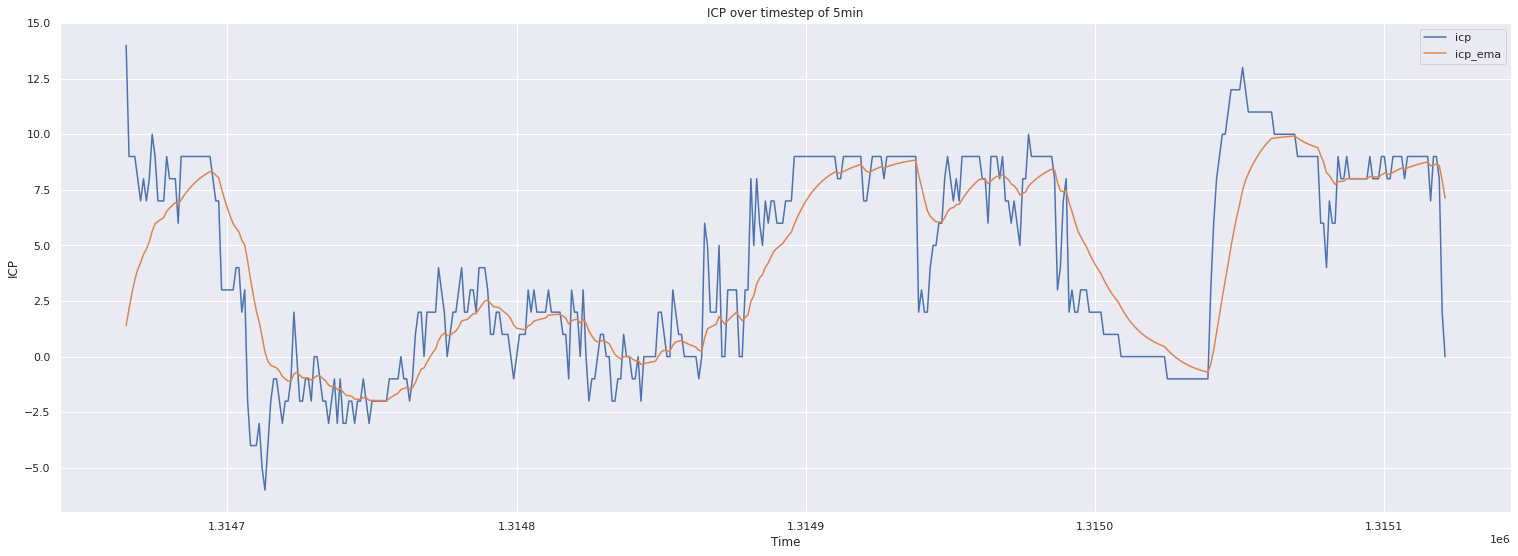

In [ ]:
eicu_diff_training[eicu_diff_training['patientunitstayid']==eicu_patient_training[20]].plot(y=['icp','icp_ema'],figsize=(26,9),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP');
# plt.xlim((1.5020e6,1.5025e6))

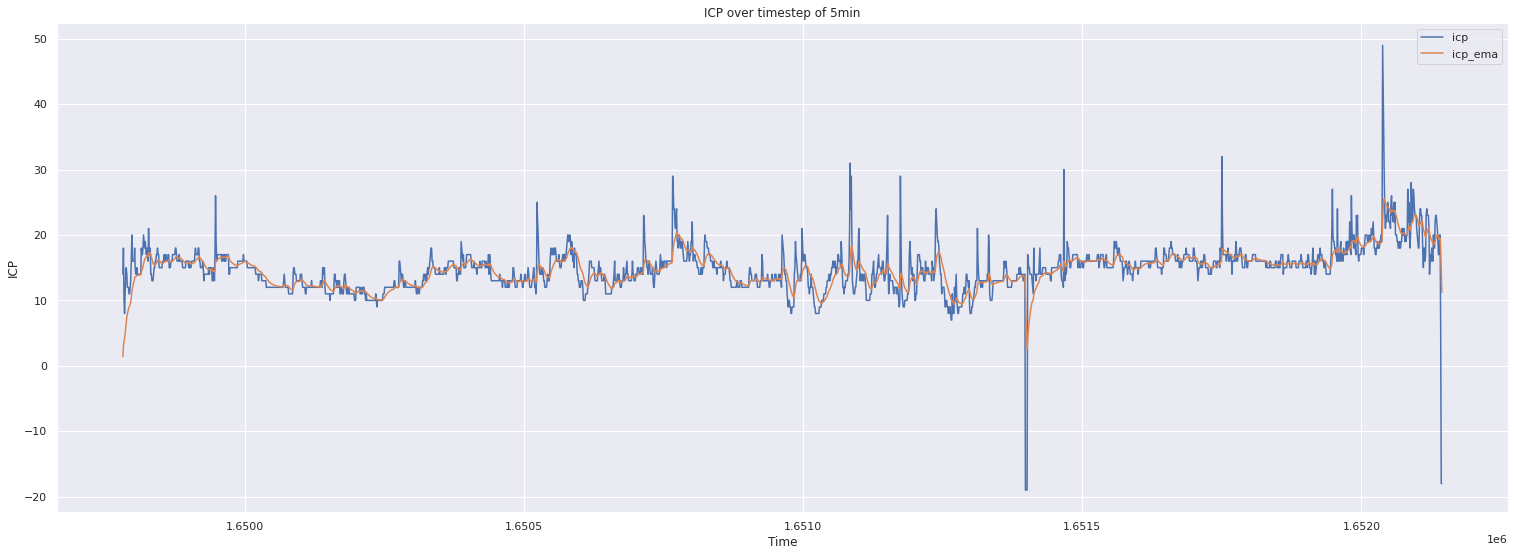

In [ ]:
eicu_diff_training[eicu_diff_training['patientunitstayid']==eicu_patient_training[-10]].plot(y=['icp','icp_ema'],figsize=(26,9),title='ICP over timestep of 5min', xlabel="Time", ylabel='ICP');

### Work with eICU data only first (5min intervals)

In [12]:
unscaled_eicu_icp_training = eicu_diff_training['icp_ema'].values.reshape((-1,1))
unscaled_eicu_icp_validation = eicu_diff_validation['icp_ema'].values.reshape((-1,1))
unscaled_eicu_icp_testing = eicu_diff_testing['icp_ema'].values.reshape((-1,1))

unscaled_static_training = eicu_static_training[['age','bmi','GCS']].values
unscaled_static_validation = eicu_static_validation[['age','bmi','GCS']].values
unscaled_static_testing = eicu_static_testing[['age','bmi','GCS']].values

scaler = RobustScaler(quantile_range=(1,99)).fit(unscaled_eicu_icp_training)
# scaler = StandardScaler().fit(unscaled_eicu_icp_training)
scaled_eicu_icp_training = scaler.transform(unscaled_eicu_icp_training)
scaled_eicu_icp_validation = scaler.transform(unscaled_eicu_icp_validation)
scaled_eicu_icp_testing = scaler.transform(unscaled_eicu_icp_testing)

scaled_eicu_icp_training = scaled_eicu_icp_training.flatten()
scaled_eicu_icp_validation = scaled_eicu_icp_validation.flatten()
scaled_eicu_icp_testing = scaled_eicu_icp_testing.flatten()

static_scaler = MinMaxScaler().fit(unscaled_static_training)
scaled_static_training = static_scaler.transform(unscaled_static_training)
scaled_static_validation = static_scaler.transform(unscaled_static_validation)
scaled_static_testing = static_scaler.transform(unscaled_static_testing)

eicu_static_training[['age_norm','bmi_norm','GCS_norm']] = scaled_static_training
eicu_static_validation[['age_norm','bmi_norm','GCS_norm']] = scaled_static_validation
eicu_static_testing[['age_norm','bmi_norm','GCS_norm']] = scaled_static_testing

eicu_diff_training['icp_ema_norm'] = scaled_eicu_icp_training
eicu_diff_validation['icp_ema_norm'] = scaled_eicu_icp_validation
eicu_diff_testing['icp_ema_norm'] = scaled_eicu_icp_testing

In [ ]:
# eicu_static_training.to_csv('./drive/MyDrive/AI Datathon/eicu_static_training.csv')
# eicu_static_testing.to_csv('./drive/MyDrive/AI Datathon/eicu_static_testing.csv')

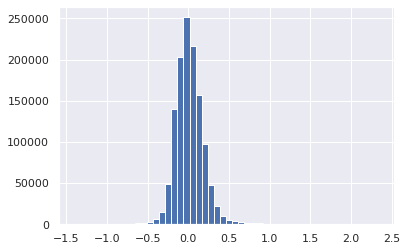

In [ ]:
plt.hist(eicu_diff_training['icp_ema_norm'], log=False,bins=50);

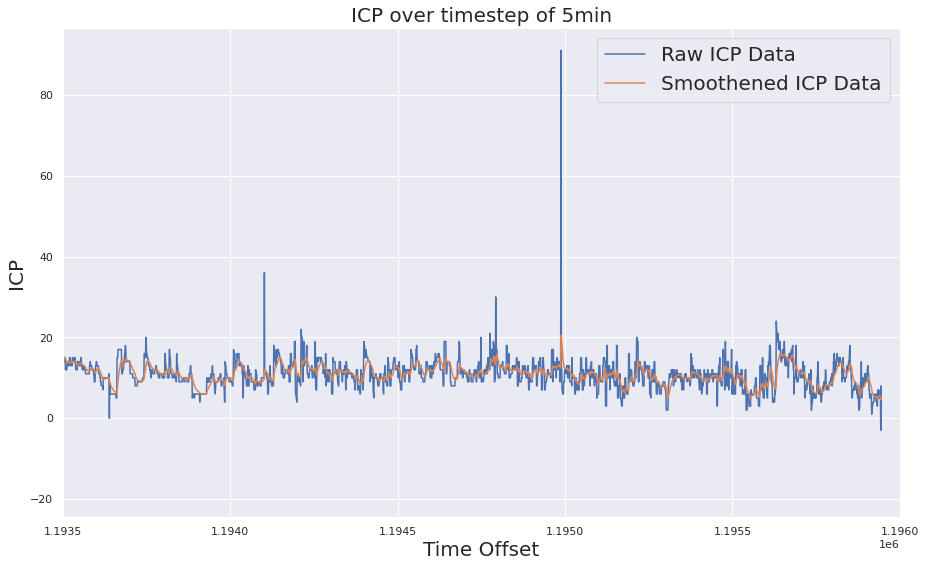

In [ ]:
eicu_diff_training[eicu_diff_training['patientunitstayid']==2768755].plot(y=['icp','icp_ema'],figsize=(15,9),title='ICP over timestep of 5min', xlabel="Time Offset", ylabel='ICP');
plt.xlim((1.1935e6,1.1960e6))
plt.xlabel("Time Offset",fontsize=20)
plt.ylabel("ICP",fontsize=20)
plt.title('ICP over timestep of 5min',fontsize=20)
plt.legend(['Raw ICP Data','Smoothened ICP Data'],fontsize=20)

# Old Sample Generation

In [ ]:
# Generate samples (old)

# Note that we are using a sliding window with m previous data, average of n future timesteps

m = 20
n = 5
count_threshold = 3
val_threshold = 0.02508019
sliding_interval = m
X_train = []
Y_train = []

for patientid in eicu_patient_training:
    patient_icp = eicu_diff_training[eicu_diff_training['patientunitstayid']==patientid]
    for s in range(0,len(patient_icp)-n-m,sliding_interval):
        X_train.append(patient_icp['icp_ema_norm'][s:s+m].values.reshape((m,1)))
        # Y_train.append(patient_icp['icp_ema_norm'][s+m:s+m+n].values.reshape((n,)))
        # v = np.average(patient_icp['icp_ema_norm'][s+m:s+m+n].values)
        v = patient_icp['icp_ema_norm'][s+m:s+m+n].values-patient_icp['icp_ema_norm'][s+m-1:s+m+n].values[0]
        if np.sum(v>val_threshold) >= count_threshold:
            Y_train.append(np.array([2]))
        elif np.sum(v<-val_threshold) >= count_threshold:
            Y_train.append(np.array([0]))
        else:
            Y_train.append(np.array([1]))
        # Y_train.append(np.array([v]))

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("Shape for X_train:",X_train.shape)
print("Shape for Y_train:",Y_train.shape)

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [ ]:
X_test = []
Y_test = []
for patient in eicu_patient_testing:
    test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==patient]

    for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
        X_test.append(test_patient_icp['icp_ema_norm'][s:s+m].values.reshape((m,1)))
        # Y_test.append(test_patient_icp['icp_ema_norm'][s+m:s+m+n].values.reshape((n,)))
        v = test_patient_icp['icp_ema_norm'][s+m:s+m+n].values-test_patient_icp['icp_ema_norm'][s+m-1:s+m+n].values[0]
        if np.sum(v>val_threshold) >= count_threshold:
            Y_test.append(np.array([2]))
        elif np.sum(v<-val_threshold) >= count_threshold:
            Y_test.append(np.array([0]))
        else:
          Y_test.append(np.array([1]))
        # Y_test.append(np.array([v]))

X_test = np.array(X_test)
Y_test = np.array(Y_test)

print("Shape for X_test:",X_test.shape)
print("Shape for Y_test:",Y_test.shape)

Shape for X_test: (9039, 20, 1)
Shape for Y_test: (9039, 1)


# New Sample Generation

In [13]:
def sample_extractor(df, static_df, patients, col_name, input_len, label_len, offset_len=0, step=0, slide=10,
                     max_samples=50, col_name_to_static=[]):
    """Generates up to <max_samples> samples from patients
    Sample window:
        ------------------------------------------------
        |       input            | offset |    label   |
        ------------------------------------------------
    :param df: dataframe of patient records
    :param static_df: dataframe of patient static records
    :param patients: list of patients to extract records from
    :param col_name: str or list of column names from df to extract as features.
                     Feature columns can only contain numeric values
    :param input_len: int Number of timestamps as input
    :param label_len: int Number of timestamps as output
    :param offset_len: int Number of timestamps to skip between input and label. Defaults to 0
    :param step: int Number of timestamps between input/output timestamps. Defaults to 0.
    :param slide: int Number of timestamps to slide the current window to extract the next sample
    :param max_samples: int Maximum number of samples to extract from each patient. Defaults to 50

    :return: np.ndarray of features extracted split as samples with shape=
             (number of samples, input_len + label_len, number of features = len(col_name))
             Input, labels can be separated from the array via:
                input, labels = array[:, :input_len, :], array[:, input_len:, :]
    """
    # samples = []
    # static_samples = []
    # input_len *= step+1
    # label_len *= step+1
    # for patient in patients:
    #     feature_time_series = df[df['patientunitstayid'] == patient][col_name].to_numpy()
    #     if len(feature_time_series.shape) == 1:
    #         feature_time_series = feature_time_series[..., np.newaxis]
    #     sample_count = 0

    #     # Extract out data that is near the 22 cutoff for ICP
    #     icp_ema = df[df['patientunitstayid'] == patient]
    #     icp_ema = icp_ema.reset_index()
    #     offsets = icp_ema.index[icp_ema['icp_ema']>15].values
    #     if len(offsets):
    #         offset_starts = [offsets[0]]
    #         for i in range(len(offsets)-1):
    #             if offsets[i+1]-offsets[i]>(input_len + offset_len+ label_len):
    #                 offset_starts.append(offsets[i+1])
    #         for start in offset_starts:
    #             if sample_count == max_samples:
    #                 break
    #             sample = np.concatenate((
    #                     feature_time_series[start:start+input_len:step+1, :],
    #                     feature_time_series[start + input_len + offset_len:start + input_len + offset_len + label_len:step+1, :]
    #                 ), axis=0)
    #             if len(sample) == (input_len + offset_len + label_len)*(step+1):
    #                 samples.append(sample)
    #                 sample_count += 1
    #                 static_samples.append(static_df[static_df['patientunitstayid']==patient].iloc[:,4:].values.flatten())

    # return np.stack(samples),np.stack(static_samples),offset_starts
    # samples = []
    # static_samples = []
    # starts = []
    # input_len *= step + 1
    # label_len *= step + 1
    # if isinstance(col_name, str):
    #     col_name = [col_name]
    # col_name += col_name_to_static
    # to_static_cols_count = len(col_name_to_static)

    # for patient in patients:
    #     feature_time_series = df[df['patientunitstayid'] == patient][col_name].to_numpy()

    #     start = 0
    #     sample_count = 0
    #     while start + input_len + offset_len + label_len < len(feature_time_series) and sample_count < max_samples:
    #         # Extract input and label features starting from <start> position

    #         if to_static_cols_count:
    #             sample = np.concatenate((
    #                 feature_time_series[start:start + input_len:step + 1, :-to_static_cols_count],
    #                 feature_time_series[
    #                 start + input_len + offset_len:start + input_len + offset_len + label_len:step + 1,
    #                 :-to_static_cols_count]
    #             ), axis=0)
    #         else:
    #             sample = np.concatenate((
    #                 feature_time_series[start:start + input_len:step + 1, :],
    #                 feature_time_series[
    #                 start + input_len + offset_len:start + input_len + offset_len + label_len:step + 1, :]
    #             ), axis=0)

    #         # set feature to maxval (for medications)
    #         converted_static_vars = []
    #         X_window = feature_time_series[start:start + input_len:step + 1, :]
    #         for i in range(1, to_static_cols_count + 1):
    #             converted_static_vars.append(np.max(X_window[:, -i]))

    #         samples.append(sample)
    #         starts.append(start + input_len)
    #         start += slide
    #         sample_count += 1
    #         # Get the patient's static info
    #         static_samples.append(
    #             np.append(static_df[static_df['patientunitstayid'] == patient].iloc[:, 4:].values.flatten(),
    #                       converted_static_vars))
    # return np.stack(samples), np.stack(static_samples), np.stack(starts)
  
    samples = []
    static_samples = []
    starts = []
    input_len *= step + 1
    label_len *= step + 1
    if isinstance(col_name, str):
        col_name = [col_name]
    col_name += col_name_to_static
    to_static_cols_count = len(col_name_to_static)

    for patient in patients:
        feature_time_series = df[df['patientunitstayid'] == patient][col_name].to_numpy()

        start = 0
        sample_count = 0
        while start + input_len + offset_len + label_len < len(feature_time_series) and sample_count < max_samples:
            # Extract input and label features starting from <start> position

            if to_static_cols_count:
                sample = np.concatenate((
                    feature_time_series[start:start + input_len:step + 1, :-to_static_cols_count],
                    feature_time_series[
                    start + input_len + offset_len:start + input_len + offset_len + label_len:step + 1,
                    :-to_static_cols_count]
                ), axis=0)
            else:
                sample = np.concatenate((
                    feature_time_series[start:start + input_len:step + 1, :],
                    feature_time_series[
                    start + input_len + offset_len:start + input_len + offset_len + label_len:step + 1, :]
                ), axis=0)

            # set feature to maxval (for medications)
            converted_static_vars = []
            X_window = feature_time_series[start:start + input_len:step + 1, :]
            for i in range(1, to_static_cols_count + 1):
                converted_static_vars.append(np.max(X_window[:, -i]))

            samples.append(sample)
            starts.append(start + input_len)
            start += slide
            sample_count += 1
            # Get the patient's static info
            static_samples.append(
                np.append(static_df[static_df['patientunitstayid'] == patient].iloc[:, 4:].values.flatten(),
                          converted_static_vars))

        if sample_count > max_samples:
            np.random.seed(1)
            chosen_sample_index = np.random.choice(max_samples, replace=False)
            n_samples, n_static_samples = [], []
            for idx in chosen_sample_index:
                n_samples.append(samples[idx])
                n_static_samples, append(static_samples[idx])
            samples, static_samples = n_samples, n_static_samples

    return np.stack(samples), np.stack(static_samples), np.stack(starts)
    
m = 18
n = 12
sliding_interval = m
step = 0

In [14]:
training_samples, training_static_samples,_ = sample_extractor(eicu_diff_training, eicu_static_training, eicu_patient_training, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
validation_samples, validation_static_samples,_ = sample_extractor(eicu_diff_validation, eicu_static_validation, eicu_patient_validation, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
testing_samples, testing_static_samples,_ = sample_extractor(eicu_diff_testing, eicu_static_testing, eicu_patient_testing, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])

X_train, _ = training_samples[:,:m,:], training_samples[:,m:,:]
X_val, _ = validation_samples[:,:m,:], validation_samples[:,m:,:]
X_test, _ = testing_samples[:,:m,:], testing_samples[:,m:,:]

training_samples, training_static_samples,_ = sample_extractor(eicu_diff_training, eicu_static_training, eicu_patient_training, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
validation_samples, validation_static_samples,_ = sample_extractor(eicu_diff_validation, eicu_static_validation, eicu_patient_validation, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
testing_samples, testing_static_samples,_ = sample_extractor(eicu_diff_testing, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])

X_train_unnorm, Y_train_unproc = training_samples[:,:m,:], training_samples[:,m:,:]
X_val_unnorm, Y_val_unproc = validation_samples[:,:m,:], validation_samples[:,m:,:]
X_test_unnorm, Y_test_unproc = testing_samples[:,:m,:], testing_samples[:,m:,:]

In [15]:
# Engineer y values
Y_train = []
Y_val = []
Y_test = []

for idx, arr in enumerate(Y_train_unproc):
    Y_train.append(np.array([1 if np.any(arr>22) else 0]))
Y_train = np.array(Y_train)

for idx, arr in enumerate(Y_val_unproc):
    Y_val.append(np.array([1 if np.any(arr>22) else 0]))
Y_val = np.array(Y_val)

for idx, arr in enumerate(Y_test_unproc):
    Y_test.append(np.array([1 if np.any(arr>22) else 0]))
Y_test = np.array(Y_test)

In [16]:
print(X_train.shape,X_val.shape,X_test.shape,'\n',Y_train.shape,Y_val.shape,Y_test.shape,'\n',training_static_samples.shape,validation_static_samples.shape,testing_static_samples.shape)

(24038, 18, 1) (3432, 18, 1) (6763, 18, 1) 
 (24038, 1) (3432, 1) (6763, 1) 
 (24038, 7) (3432, 7) (6763, 7)


# Model

### Hyperparameters

In [17]:
batch_size = 128
num_lstm_neurons = [100,100]
num_dense_neurons= [50]

num_static_neurons = [50]
dropout = 0.1
epochs = 20
folder_dir ='./drive/MyDrive/AI Datathon/Models/Day3/ICP_hsmcumsurg_step=%s_m=%s_n=%s_22_updatedsampling/'%(step,m,n)
print(folder_dir)

./drive/MyDrive/AI Datathon/Models/Day3/ICP_hsmcumsurg_step=0_m=18_n=12_22_updatedsampling/


In [18]:
class PredictionCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test, loss):
        self.X_test = X_test
        self.Y_test = Y_test
        self.loss = loss
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_test)
        self.loss.append(mean_absolute_error(y_true=self.Y_test.reshape((self.Y_test.shape[0],self.Y_test.shape[1])), y_pred=y_pred.reshape((y_pred.shape[0],y_pred.shape[1]))))
        print('\n',self.loss[-1])

def compute_binary_specificity(y_pred, y_true):
    """Compute the confusion matrix for a set of predictions.

    Parameters
    ----------
    y_pred   : predicted values for a batch if samples (must be binary: 0 or 1)
    y_true   : correct values for the set of samples used (must be binary: 0 or 1)

    Returns
    -------
    out : the specificity
    """

    TN = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 0)
    FP = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 1)

    # as Keras Tensors
    TN = K.sum(K.variable(TN))
    FP = K.sum(K.variable(FP))

    specificity = TN / (TN + FP + K.epsilon())
    return specificity


def compute_binary_sensitivity(y_pred, y_true):
    """Compute the confusion matrix for a set of predictions.

    Parameters
    ----------
    y_pred   : predicted values for a batch if samples (must be binary: 0 or 1)
    y_true   : correct values for the set of samples used (must be binary: 0 or 1)

    Returns
    -------
    out : the sensitivity
    """

    FN = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 0)
    TP = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 1)

    # as Keras Tensors
    FN = K.sum(K.variable(FN))
    TP = K.sum(K.variable(TP))

    sensitivity = TP / (TP + FN + K.epsilon())
    return sensitivity


model_checkpoint_callback = ModelCheckpoint(
    filepath=folder_dir+'{epoch:02d}_{val_accuracy:.4f}.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

auc = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, num_labels=None, label_weights=None,
    from_logits=False
)

def sensitivity_loss_wrapper():
    """A wrapper to create and return a function which computes the sensitivity loss, as (1 - sensitivity)

    """
    # Define the function for your loss
    def sensitivity_loss(y_true, y_pred):
        return 1.0 - compute_binary_sensitivity(np.argmax(y_pred,axis=1), y_true.flatten())

sens_loss = sensitivity_loss_wrapper()


lstm_model = Sequential()
"""
LSTM

    - units = dimension of hidden state. Hidden state is like an output of LSTM 
    in every timestep. This means our LSTM will be outputting <units> real numbers 
    in the end. It also means, the amount of neurons in every layer of the neuron
    in LSTM is <units>. Note that in LSTM, we have the forget gate, input gate
    and output gate.

    - input_shape = (timesteps,no. of params)
    
    - return_sequences = True is necessary when chaining LSTM layers, so that
    the second LSTM layer has a three-dimensional sequence input
"""
for s in range(len(num_lstm_neurons)):
    if s == 0:
        lstm_model.add(LSTM(units=num_lstm_neurons[s], dropout=dropout, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    elif s == len(num_lstm_neurons)-1:
        lstm_model.add(LSTM(units=num_lstm_neurons[s], dropout=dropout))
    else:
        lstm_model.add(LSTM(units=num_lstm_neurons[s], return_sequences=True, dropout=dropout))

for k in range(len(num_dense_neurons)):
    lstm_model.add(Dense(units=num_dense_neurons[k],activation='relu'))
    lstm_model.add(Dropout(dropout))


# Static model
static_model = Sequential()
static_model.add(Input(shape=(training_static_samples.shape[1],)))
for s in range(len(num_static_neurons)):
    static_model.add(Dense(units=num_static_neurons[s],activation='relu'))
    static_model.add(Dropout(dropout))

concat = Concatenate()([lstm_model.output, static_model.output])
z = Dense(units=2)(concat)
z = Softmax()(z)
merged_model = Model(inputs=[lstm_model.input, static_model.input], outputs=z)

opt = Adam(learning_rate=0.001)
merged_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# merged_model.compile(optimizer=opt, loss=sens_loss, metrics=['accuracy'])
merged_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, 18, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 18, 100)      40800       ['lstm_input[0][0]']             
                                                                                                  
 lstm_1 (LSTM)                  (None, 100)          80400       ['lstm[0][0]']                   
                                                                                                  
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                              

In [19]:
history = merged_model.fit([X_train, training_static_samples], Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=([X_val,validation_static_samples], Y_val), callbacks=[model_checkpoint_callback])

Epoch 1/20
188/188 [==============================] - 20s 89ms/step - loss: 0.1321 - accuracy: 0.9585 - val_loss: 0.0822 - val_accuracy: 0.9790
Epoch 2/20
188/188 [==============================] - 15s 82ms/step - loss: 0.0805 - accuracy: 0.9773 - val_loss: 0.0713 - val_accuracy: 0.9819
Epoch 3/20
188/188 [==============================] - 15s 80ms/step - loss: 0.0730 - accuracy: 0.9786 - val_loss: 0.0784 - val_accuracy: 0.9781
Epoch 4/20
188/188 [==============================] - 15s 80ms/step - loss: 0.0713 - accuracy: 0.9783 - val_loss: 0.0755 - val_accuracy: 0.9816
Epoch 5/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0670 - accuracy: 0.9789 - val_loss: 0.0490 - val_accuracy: 0.9837
Epoch 6/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0703 - accuracy: 0.9794 - val_loss: 0.0538 - val_accuracy: 0.9834
Epoch 7/20
188/188 [==============================] - 15s 80ms/step - loss: 0.0691 - accuracy: 0.9806 - val_loss: 0.0498 - val_accuracy:

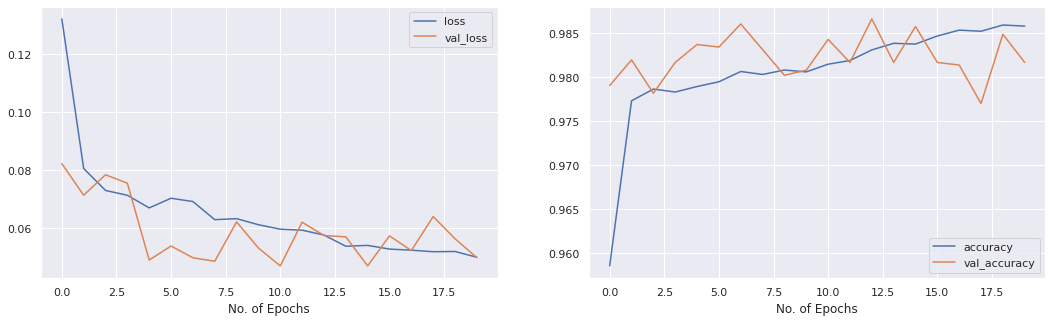

In [20]:
results = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(1,2)
results.plot(y=['loss','val_loss'],ax=ax1,figsize=(18,5),xlabel='No. of Epochs')
results.plot(y=['accuracy','val_accuracy'],ax=ax2,xlabel='No. of Epochs')

In [21]:
# best_model = keras.models.load_model(folder_dir+'18_0.9900.hdf5')
best_model = keras.models.load_model(folder_dir+'%s_%.4f.hdf5'%(1+np.argmax(results['val_accuracy'].values),np.max(results['val_accuracy'].values)))

# tf_explain

IndexError: ignored

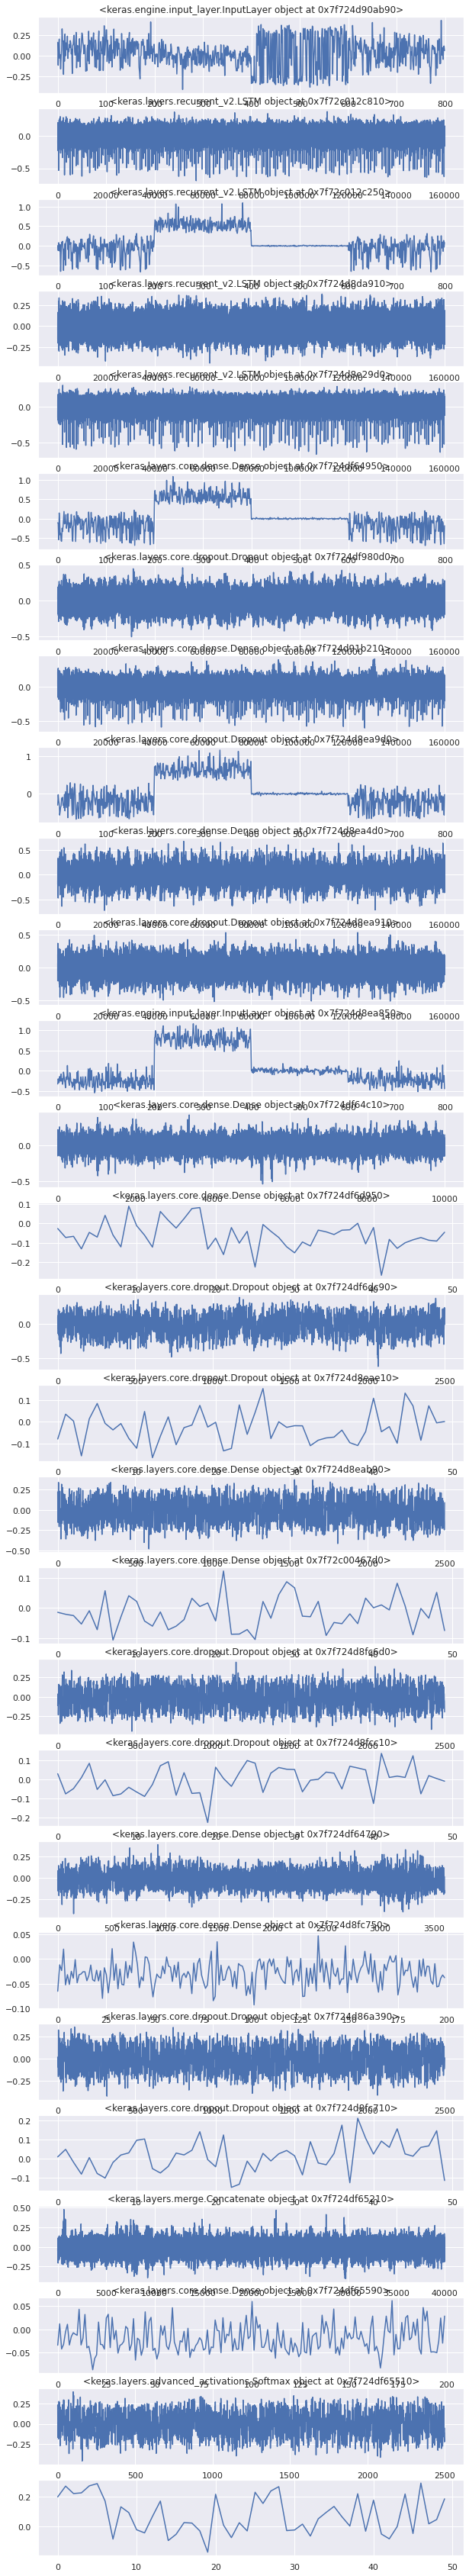

In [ ]:
weights = best_model.weights
fig = plt.figure(figsize=(10,70))
for i in range(len(weights)):
    ax = fig.add_subplot(len(weights),1,i+1)
    ax.plot(weights[i].numpy().flatten())
    ax.set_title(best_model.layers[i])

In [ ]:
best_model.layers

# Testing EMA Classification Model 

1081359


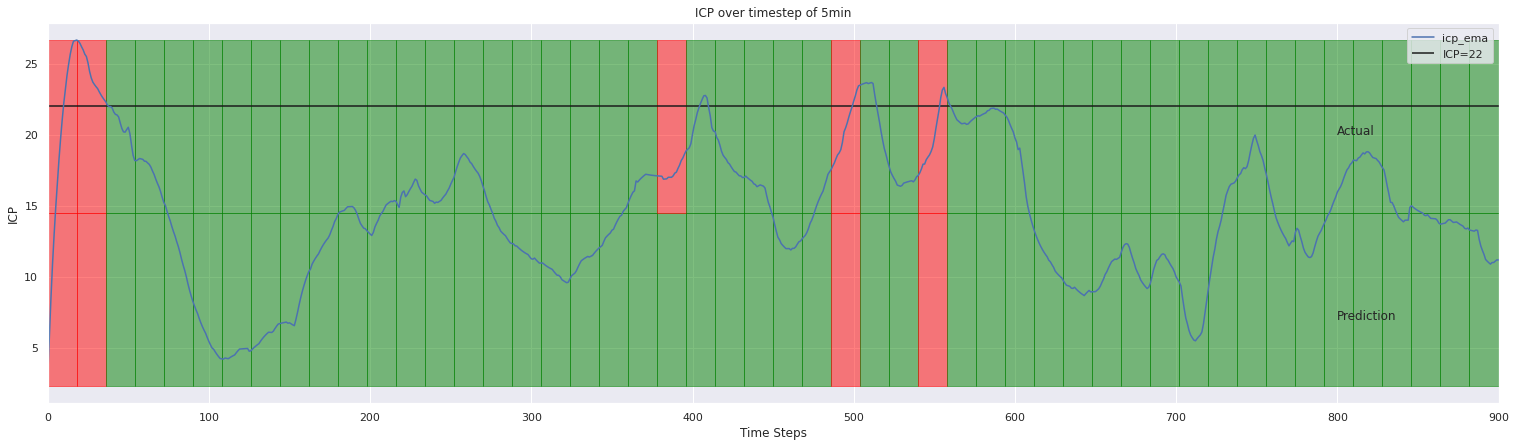

In [ ]:
fig, ax = plt.subplots()
print(eicu_patient_testing[2])
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[2]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,900))
plt.text(800, 7, "Prediction")
plt.text(800, 20, "Actual")
plt.legend()

3049681


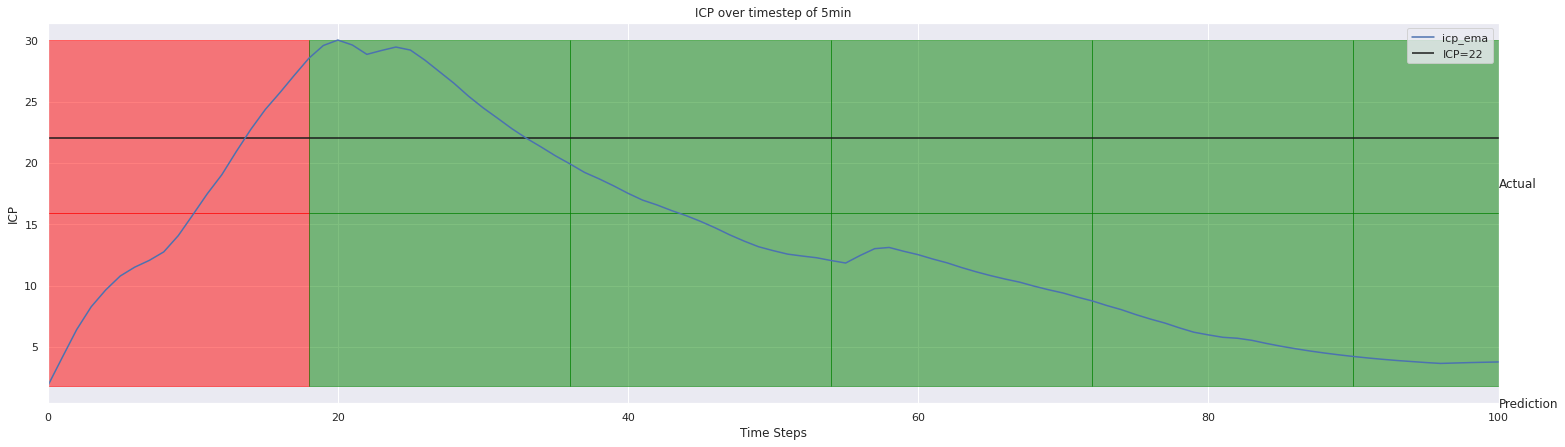

In [ ]:
fig, ax = plt.subplots()
print(eicu_patient_testing[30])
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[30]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['Culmulative hypertonic saline','Culmulative mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['Culmulative hypertonic saline','Culmulative mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,100))
plt.text(100, 0, "Prediction")
plt.text(100, 18, "Actual")
plt.legend()

3207930


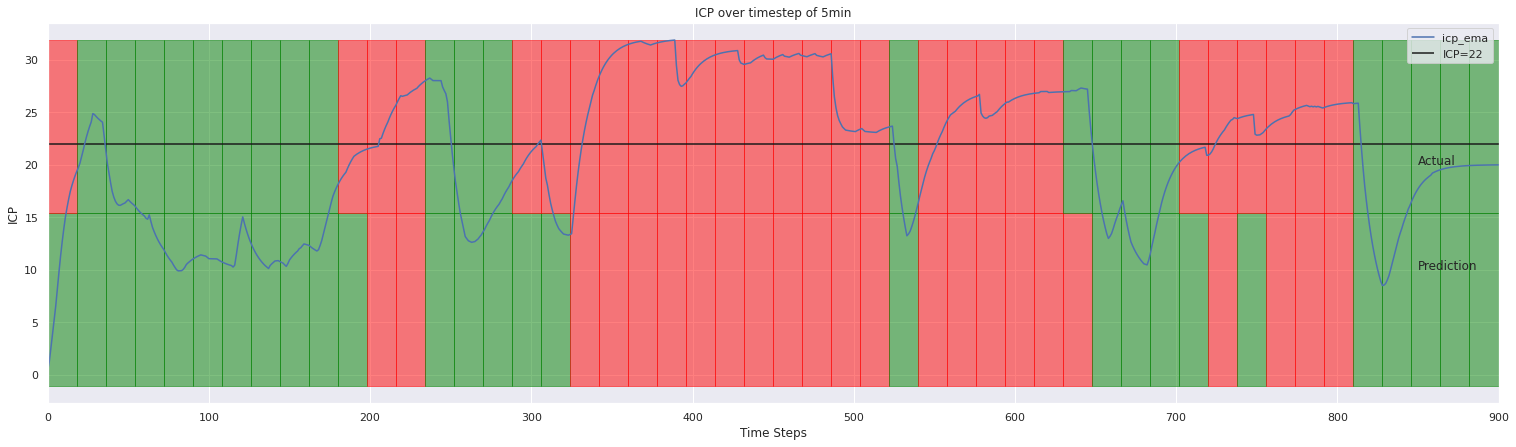

In [ ]:
fig, ax = plt.subplots()
print(eicu_patient_testing[89])
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[89]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema_norm',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['Culmulative hypertonic saline','Culmulative mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step,col_name_to_static=['Culmulative hypertonic saline','Culmulative mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,900))
plt.text(850, 10, "Prediction")
plt.text(850, 20, "Actual")
plt.legend()

In [ ]:
# Calculate sensitivity and specificity
Y_pred = best_model.predict([X_test, testing_static_samples])
res = compute_binary_sensitivity(np.argmax(Y_pred,axis=1), Y_test.flatten())
sensitivity = float(res)
res = compute_binary_specificity(np.argmax(Y_pred,axis=1), Y_test.flatten())
specificity = float(res)
print("Sensitivity:%s, Specificity:%s"%(sensitivity,specificity))

Sensitivity:0.7478510141372681, Specificity:0.9996981620788574


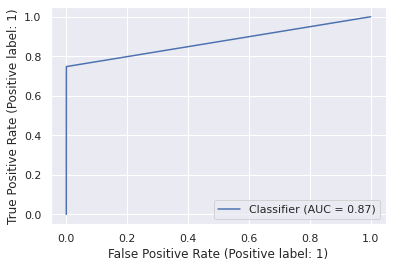

In [ ]:
RocCurveDisplay.from_predictions(Y_test.flatten(), np.argmax(Y_pred,axis=1), pos_label=1)

# Testing Model with Updated Sampling

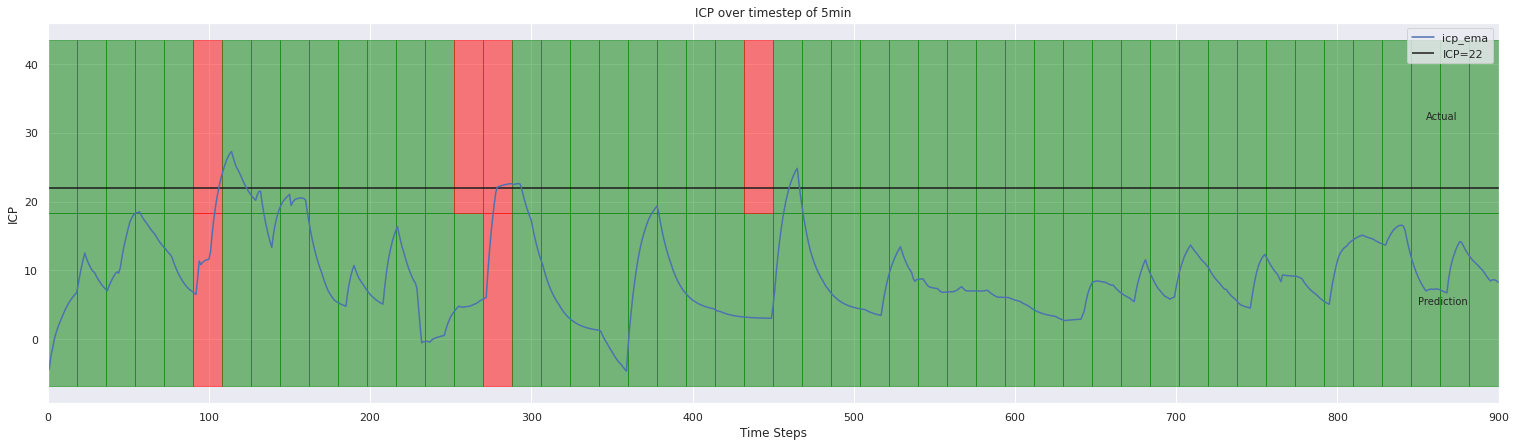

In [22]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_diff_testing['patientunitstayid'].unique()[46]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, ['icp_ema_norm'],input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
# X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,900))
plt.text(850, 5, "Prediction")
plt.text(855, 32, "Actual")
plt.legend()

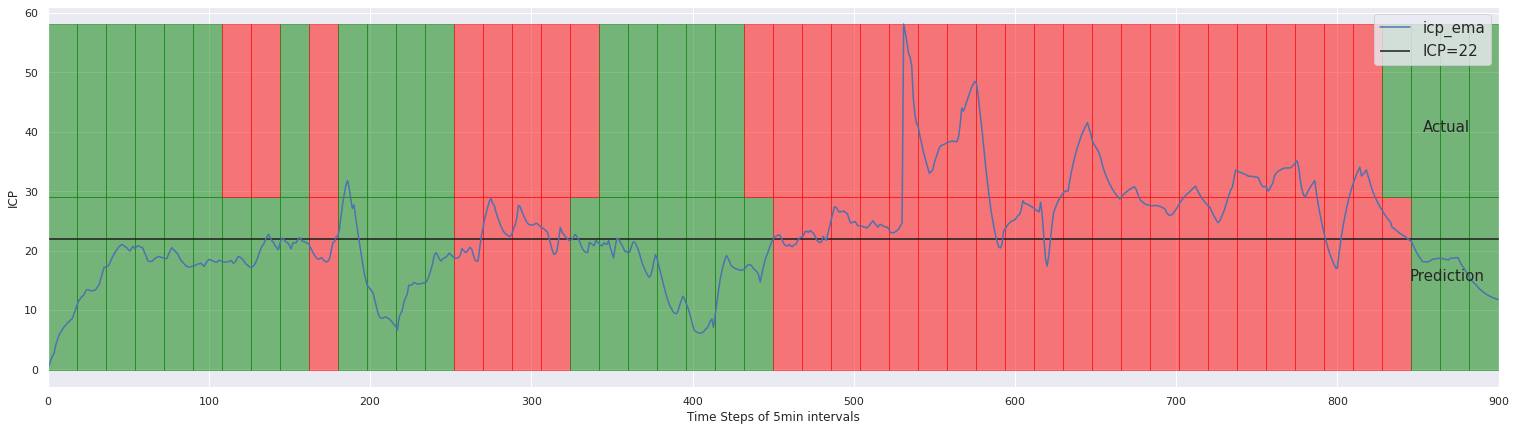

In [31]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_diff_testing['patientunitstayid'].unique()[97]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, ['icp_ema_norm'],input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
# X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,900))
plt.text(845, 15, "Prediction",fontsize=15)
plt.text(853, 40, "Actual",fontsize=15)
plt.xlabel("Time Steps of 5min intervals")
plt.ylabel("ICP")
plt.title('')
plt.legend(fontsize=15)

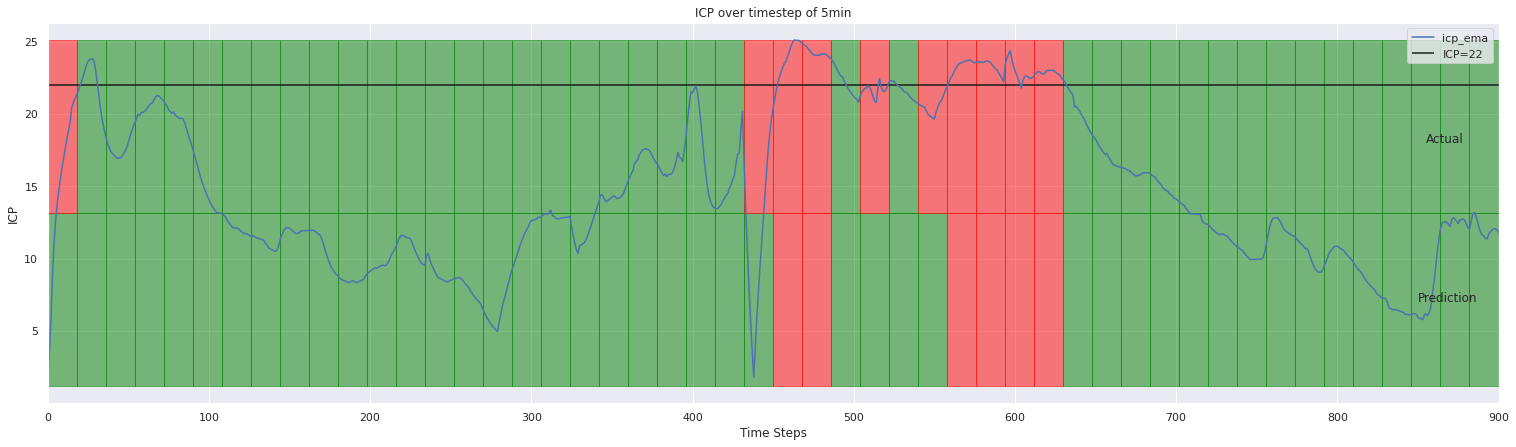

In [30]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_diff_testing['patientunitstayid'].unique()[95]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(26,7),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

testing_samples_single, testing_static_samples_single, time = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, ['icp_ema_norm'],input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
# mid_offset_starts=np.array(offset_starts)+m
X_test_single, _ = testing_samples_single[:,:m], testing_samples_single[:,m:]
# X_test_single = X_test_single.reshape((X_test_single.shape[0],X_test_single.shape[1],1))

testing_samples_single, _ , _ = sample_extractor(test_patient_icp, eicu_static_testing, eicu_patient_testing, 'icp_ema',input_len=m, label_len=n,slide=sliding_interval,step=step, col_name_to_static=['hypertonic saline','mannitol']+['Culmulative Intracranial operations', 'Culmulative Shunting'])
_, Y_true = testing_samples_single[:,:m], testing_samples_single[:,m:]

Y_true_single = []
for idx, arr in enumerate(Y_true):
    Y_true_single.append(np.array([1 if np.any(arr>22) else 0]))
Y_true_single = np.array(Y_true_single)
y_pred = best_model.predict([X_test_single, testing_static_samples_single])

for t in range(len(time)):
    if np.argmax(y_pred[t]) == 0:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']), (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='green',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='green',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none') # xerr=np.array([[m],[n]])
    else:
        ax.fill_between([time[t]-sliding_interval,time[t]], min(test_patient_icp['icp_ema']),  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, color='red',alpha=0.5)
        # ax.errorbar([time[t]],[test_patient_icp['icp_ema'][time[t]]-1], color='red',alpha=np.max(y_pred[t]), marker="o", markersize=10,ls='none')

for t in range(len(time)):
    if Y_true_single[t][0] == 0:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='green',alpha=1, marker="x", markersize=10,ls='none') # xerr=np.array([[m],[n]])
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        # ax.errorbar([time[t]-sliding_interval/2],[test_patient_icp['icp_ema'][time[t]]], color='red',alpha=1, marker="x", markersize=10,ls='none')
        ax.fill_between([time[t]-sliding_interval,time[t]],  (min(test_patient_icp['icp_ema'])+max(test_patient_icp['icp_ema']))/2, max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
plt.hlines(xmin=0,xmax=1000,y=22,label='ICP=22')
plt.xlim((0,900))
plt.text(850, 7, "Prediction")
plt.text(855, 18, "Actual")
plt.legend()

In [25]:
# Calculate sensitivity and specificity
Y_pred = best_model.predict([X_test, testing_static_samples])
res = compute_binary_sensitivity(np.argmax(Y_pred,axis=1), Y_test.flatten())
sensitivity = float(res)
res = compute_binary_specificity(np.argmax(Y_pred,axis=1), Y_test.flatten())
specificity = float(res)
print("Sensitivity:%s, Specificity:%s"%(sensitivity,specificity))

Sensitivity:0.7983871102333069, Specificity:0.9984353184700012


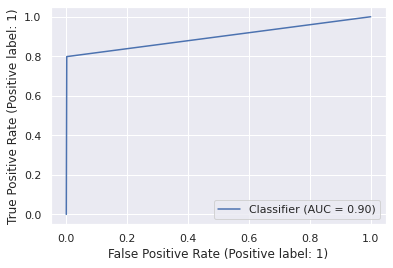

In [26]:
RocCurveDisplay.from_predictions(Y_test.flatten(), np.argmax(Y_pred,axis=1), pos_label=1)

0.9984352996401189 0.7983870967741935 0.9674267100977199 0.9883828996282528
[[6381   10]
 [  75  297]]


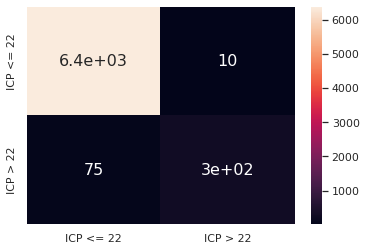

In [29]:
cm = confusion_matrix(Y_test.flatten(), np.argmax(Y_pred,axis=1))
spec = cm[0][0]/(cm[0][0]+cm[0][1])
sens = cm[1][1]/(cm[1][0]+cm[1][1])
ppv = cm[1][1]/(cm[0][1]+cm[1][1])
npv = cm[0][0]/(cm[0][0]+cm[1][0])
print(spec,sens,ppv,npv)
print(cm)
# spec = cm[0][0]/(cm[0][0]+cm[1][0])
# ConfusionMatrixDisplay.from_predictions(Y_test.flatten(), np.argmax(Y_pred,axis=1))
confusion_df = pd.DataFrame(cm, index=["ICP <= 22", "ICP > 22"], columns=["ICP <= 22", "ICP > 22"])
sns.heatmap(cm, annot=True, annot_kws={"size": 16},xticklabels=["ICP <= 22", "ICP > 22"],yticklabels=["ICP <= 22", "ICP > 22"])

# Testing Model

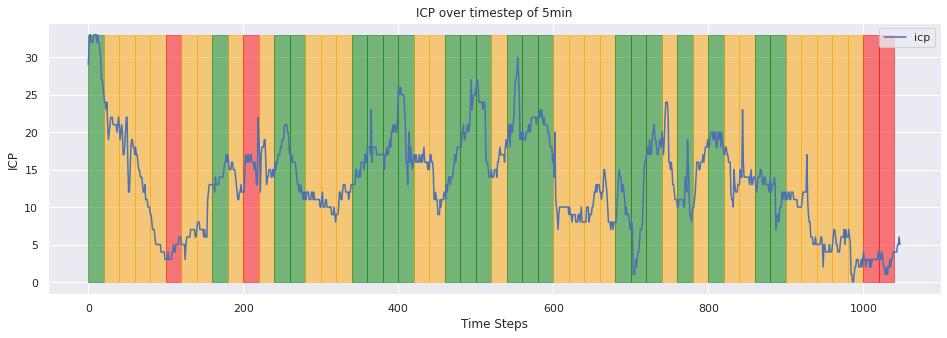

In [ ]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[10]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

X_test_single = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    X_test_single.append(test_patient_icp['icp_norm'][s:s+m].values.reshape((m,1)))

X_test_single = np.array(X_test_single)
y_pred_norm = model.predict(X_test_single)
y_pred = scaler.inverse_transform(y_pred_norm)
time = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    time.append(s)

y_pred = y_pred.flatten()
for t in range(len(time)):
    if y_pred[t] - test_patient_icp['icp'][time[t]+sliding_interval-1] > 1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp']), max(test_patient_icp['icp']), color='red',alpha=0.5)
    elif y_pred[t] - test_patient_icp['icp'][time[t]+sliding_interval-1] < -1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp']), max(test_patient_icp['icp']), color='green',alpha=0.5)
    else:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp']), max(test_patient_icp['icp']), color='orange',alpha=0.5)

# Testing EMA Model

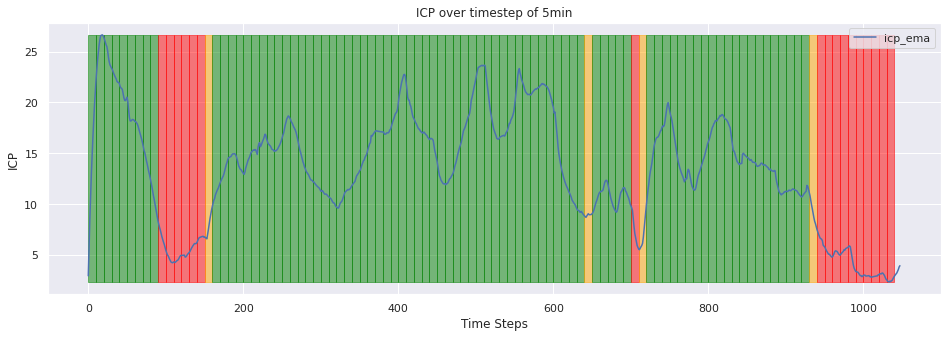

In [ ]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[1]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

X_test_single = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    X_test_single.append(test_patient_icp['icp_ema_norm'][s:s+m].values.reshape((m,1)))

X_test_single = np.array(X_test_single)
y_pred_norm = model.predict(X_test_single)
y_pred = scaler.inverse_transform(y_pred_norm)
time = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    time.append(s)

y_pred = y_pred.flatten()
for t in range(len(time)):
    if y_pred[t] - test_patient_icp['icp_ema'][time[t]+sliding_interval-1] > 1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
    elif y_pred[t] - test_patient_icp['icp_ema'][time[t]+sliding_interval-1] < -1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='orange',alpha=0.5)

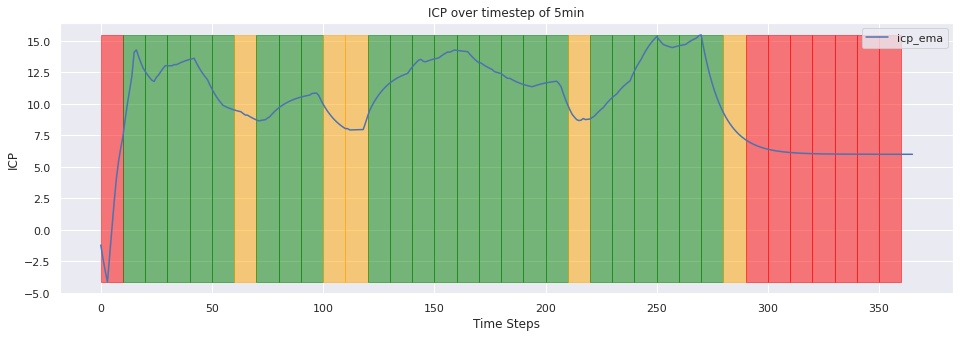

In [ ]:
fig, ax = plt.subplots()
test_patient_icp = eicu_diff_testing[eicu_diff_testing['patientunitstayid']==eicu_patient_testing[6]]
test_patient_icp = test_patient_icp.reset_index()
test_patient_icp.plot(y=['icp_ema'],figsize=(16,5),title='ICP over timestep of 5min', xlabel="Time Steps", ylabel='ICP',ax=ax)

X_test_single = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    X_test_single.append(test_patient_icp['icp_ema_norm'][s:s+m].values.reshape((m,1)))

X_test_single = np.array(X_test_single)
y_pred_norm = model.predict(X_test_single)
y_pred = scaler.inverse_transform(y_pred_norm)
time = []
for s in range(0,len(test_patient_icp)-m-n, sliding_interval):
    time.append(s)

y_pred = y_pred.flatten()
for t in range(len(time)):
    if y_pred[t] - test_patient_icp['icp_ema'][time[t]+sliding_interval-1] > 1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='red',alpha=0.5)
    elif y_pred[t] - test_patient_icp['icp_ema'][time[t]+sliding_interval-1] < -1:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='green',alpha=0.5)
    else:
        ax.fill_between([time[t],time[t]+sliding_interval], min(test_patient_icp['icp_ema']), max(test_patient_icp['icp_ema']), color='orange',alpha=0.5)